# Summary
This demonstrates reconstruction of a Fresnel CDI dataset and compares the result to ePIE reconstruction. 

The probe structure allows reconstruction in CDI mode, i.e. without real-space overlap constraints. 

Scanning CDI reconstruction is also possible here, but results in a lower-quality image because of scan position jitter in this dataset.

## Object ePIE reconstruction: 
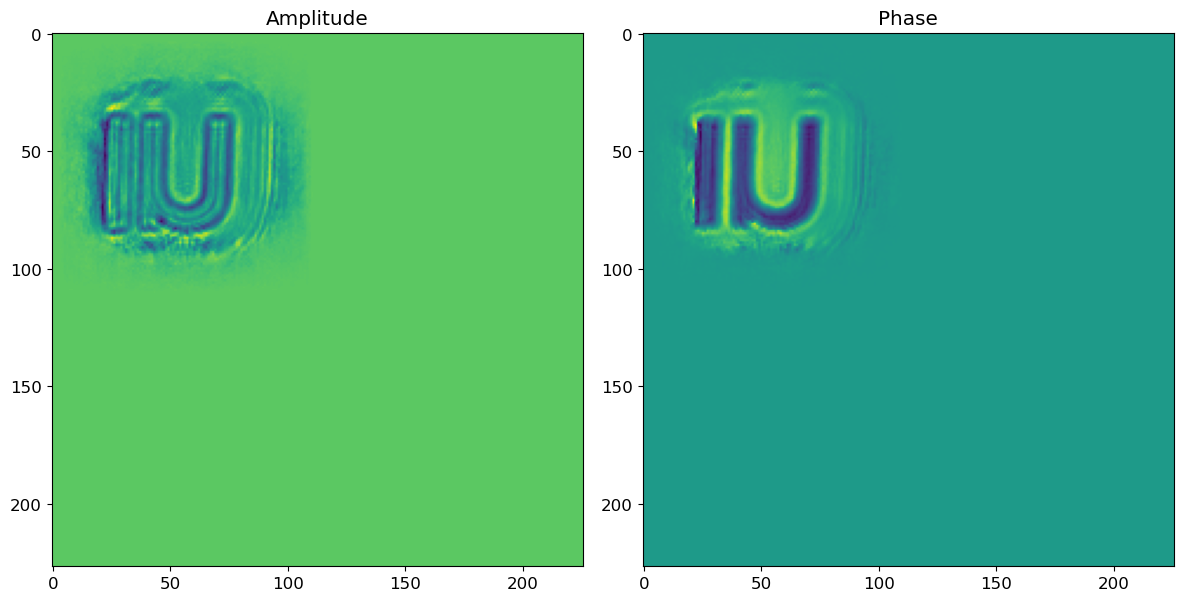

In [3]:
from scipy.ndimage import zoom
import numpy as np

def init():
    from ptycho import params as p
    
    p.cfg['nepochs'] = 50
    p.cfg['output_prefix'] = 'tmp'
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1
    p.cfg['intensity_scale.trainable'] = False
    p.cfg['positions.provided'] = True
    p.cfg['probe.big'] = True
    p.cfg['probe.mask'] = False

    p.cfg['amp_activation'] = 'sigmoid'
    p.cfg['nphotons'] = 1e7
    p.cfg['N'] = 128
    p.cfg['nll_weight'] = 0
    p.cfg['mae_weight'] = 1

    p.cfg['data_source'] = 'generic'
    p.cfg['gridsize'] = 1
    p.cfg['probe_scale'] = 4
    p.cfg['train_data_file_path'] = 'train_data.npz'
    p.cfg['test_data_file_path'] = 'test_data.npz'


# IMPORTANT: must call init() BEFORE the dataset definition
init()

In [4]:
# from ptycho.autotest import debug

In [5]:
# !ln -s ../../ptycho_loaders/als128.npy.npz

In [6]:
!ln -s ../tests/test_generic_loader.py
import test_generic_loader;
# train_raw, test_raw, obj = test_generic_loader.test_generic_loader(False, 'als.npy.npz', train_size = 700);
train_raw, test_raw, obj = test_generic_loader.test_generic_loader(False, 'als128.npy.npz', train_size = 700);

ln: failed to create symbolic link './test_generic_loader.py': File exists


2024-10-16 01:36:07.942070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 01:36:07.942100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 01:36:07.942954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 01:36:07.947472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 01:36:08.550228: W tensorflow/compiler/tf2

2 items had no tests:
    __main__
    __main__.init
0 tests in 2 items.
0 passed and 0 failed.
Test passed.
diff3d shape: (1087, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (1087,)
objectGuess shape: (227, 226)
xcoords shape: (1087,)
ycoords shape: (1087,)
xcoords_start shape: (1087,)
ycoords_start shape: (1087,)
diff3d shape: (512, 64, 64)
probeGuess shape: (64, 64)
scan_index shape: (512,)
objectGuess shape: (227, 226)
xcoords shape: (512,)
ycoords shape: (512,)
xcoords_start shape: (512,)
ycoords_start shape: (512,)
raw diffraction shape (64, 64, 1087)
diff3d shape: (1600, 128, 128)
probeGuess shape: (128, 128)
scan_index shape: (1600,)
objectGuess shape: (710, 710)
xcoords shape: (1600,)
ycoords shape: (1600,)
xcoords_start shape: (1600,)
ycoords_start shape: (1600,)
diff3d shape: (700, 128, 128)
probeGuess shape: (128, 128)
scan_index shape: (700,)
objectGuess shape: (710, 710)
xcoords shape: (700,)
ycoords shape: (700,)
xcoords_start shape: (700,)
ycoords_start shape: (

In [7]:
train_raw.probeGuess[:, ::-1].shape

(128, 128)

In [8]:
from ptycho import probe
from ptycho import params as p

# #mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
# mask = np.absolute(probe.get_probe_mask(p.get('N')))[:, :, 0, 0]
#probe.set_probe_guess(None, np.transpose(train_raw.probeGuess[::-1, ::-1]))
probe.set_probe_guess(None, train_raw.probeGuess[:, ::-1])

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

DEBUG: Setting probe to tf.Tensor(
[[[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 ...

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]

 [[0.+0.j]
  [0.+0.j]
  [0.+0.j]
  ...
  [0.+0.j]
  [0.+0.j]
  [0.+0.j]]], shape=(128, 128, 1), dtype=complex64) in params


In [9]:
# np.save('xprobe0.npz', probeGuess)

In [10]:
import tensorflow as tf

tf.random.set_seed(45)
np.random.seed(45)
from ptycho import params as p
from ptycho import train, model
from ptycho.train import *
from ptycho.nbutils import *

# channel dimensions size should be 1 in CDI mode, 4 in ptycho mode
ptycho_dataset.test_data.X.shape, ptycho_dataset.train_data.X.shape

DEBUG: Setting timestamp to 10/16/2024, 01:36:11 in params
diff3d shape: (700, 128, 128)
probeGuess shape: (128, 128)
scan_index shape: (700,)
objectGuess shape: (710, 710)
xcoords shape: (700,)
ycoords shape: (700,)
xcoords_start shape: (700,)
ycoords_start shape: (700,)
diff3d shape: (1600, 128, 128)
probeGuess shape: (128, 128)
scan_index shape: (1600,)
objectGuess shape: (710, 710)
xcoords shape: (1600,)
ycoords shape: (1600,)
xcoords_start shape: (1600,)
ycoords_start shape: (1600,)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (700, 128, 128, 1)
DEBUG: nsamples: 1
neighbor-sampled diffraction shape (1600, 128, 128, 1)
loader: setting dummy Y ground truth
INFO: None
<PtychoDataContainer X=(700, 128, 128, 1) Y_I=(700, 128, 128, 1) Y_phi=(700, 128, 128, 1) norm_Y_I=() coords_nominal=(700, 1, 2, 1) coords_true=(700, 1, 2, 1) nn_indices=(700, 1) mean=349.500 global_offsets=(700, 1, 2, 1) mean=28.827 local_offsets=(700, 1, 2, 1) mean=0.000 probe=(128, 128, 1)>
loader: setting d

2024-10-16 01:36:14.206620: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-10-16 01:36:14.206637: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-10-16 01:36:14.206661: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-10-16 01:36:14.227895: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:163] cuptiEnableCallback: error 1: CUPTI_ERROR_INVALID_PARAMETER
2024-10-16 01:36:14.227909: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-10-16 01:36:14.227913: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-10-16 01:36:14.227920: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
202

Epoch 1/50
input shape (None, 128, 128, 1)
input shape (None, 128, 128, 1)


2024-10-16 01:36:17.399396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-10-16 01:36:17.725608: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5b154008b770
2024-10-16 01:36:18.922753: I external/local_xla/xla/service/service.cc:168] XLA service 0x71e5243c4130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-16 01:36:18.922782: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-10-16 01:36:18.926106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729056978.990138  731729 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 12s 78ms/step - loss: 3.5192 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 3.5192 - distribution_lambda_loss: 5260017.0000 - val_loss: 3.6882 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 3.6882 - val_distribution_lambda_loss: 4097974.5000 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 1s 19ms/step - loss: 2.6229 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 2.6229 - distribution_lambda_loss: 2709944.7500 - val_loss: 3.4893 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 3.4893 - val_distribution_lambda_loss: 3714381.5000 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 1s 19ms/step - loss: 2.6728 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_2_loss: 2.6728 - distribution_lambda_loss: 2881769.2500 - val_loss: 3.6071 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_2_loss: 3.6071 - val_distribution_lambda_loss: 3963427.2500 - lr: 0.0010
Ep

INFO:tensorflow:Assets written to: tmp/10-16-2024-01.36.11_//wts.h5_autoencoder/assets


INFO:tensorflow:Assets written to: tmp/10-16-2024-01.36.11_//wts.h5_diffraction_to_obj/assets


INFO:tensorflow:Assets written to: tmp/10-16-2024-01.36.11_//wts.h5_diffraction_to_obj/assets


(TensorShape([1600, 128, 128, 1]), TensorShape([700, 128, 128, 1]))

1, 1, 1
42/42 [==============================] - 0s 10ms/step - loss: 30120.8965 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.8305 - distribution_lambda_loss: 30120.8965 - val_loss: 41455.5078 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.9339 - val_distribution_lambda_loss: 41455.5078 - lr: 1.0000e-04


-1, 1, 1
42/42 [==============================] - 0s 11ms/step - loss: 13293.1162 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.7165 - distribution_lambda_loss: 13293.1162 - val_loss: 19160.1562 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.7865 - val_distribution_lambda_loss: 19160.1562 - lr: 5.0000e-04

-1, -1, 1
42/42 [==============================] - 0s 11ms/step - loss: 75953.7891 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 1.1497 - distribution_lambda_loss: 75953.7891 - val_loss: 119839.4297 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 1.4555 - val_distribution_lambda_loss: 119839.4297 - lr: 1.0000e-04

-1, -1, -1
42/42 [==============================] - 0s 11ms/step - loss: 18819.8066 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.8452 - distribution_lambda_loss: 18819.8066 - val_loss: 24448.5176 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.8893 - val_distribution_lambda_loss: 24448.5176 - lr: 2.5000e-04


-1, 1, -1
42/42 [==============================] - 0s 11ms/step - loss: 13944.5371 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.6803 - distribution_lambda_loss: 13944.5371 - val_loss: 20506.4297 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.7845 - val_distribution_lambda_loss: 20506.4297 - lr: 5.0000e-04


1, -1, 1
42/42 [==============================] - 0s 11ms/step - loss: 16341.8574 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.6898 - distribution_lambda_loss: 16341.8574 - val_loss: 22704.7539 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.7535 - val_distribution_lambda_loss: 22704.7539 - lr: 1.0000e-04

1, -1, -1
42/42 [==============================] - 0s 11ms/step - loss: 27554.1055 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.8595 - distribution_lambda_loss: 27554.1055 - val_loss: 33158.4375 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.8370 - val_distribution_lambda_loss: 33158.4375 - lr: 1.0000e-04

1, 1, -1
42/42 [==============================] - 0s 11ms/step - loss: 13981.7578 - trimmed_obj_loss: 0.0000e+00 - tf.math.multiply_loss: 0.6316 - distribution_lambda_loss: 13981.7578 - val_loss: 19203.4863 - val_trimmed_obj_loss: 0.0000e+00 - val_tf.math.multiply_loss: 0.6850 - val_distribution_lambda_loss: 19203.4863 - lr: 1.2500e-04



# Dataset description

In [9]:
print(test_raw)

RawData:
  xcoords: (1600,)
  ycoords: (1600,)
  xcoords_start: (1600,)
  ycoords_start: (1600,)
  diff3d: (1600, 128, 128)
  probeGuess: (128, 128)
  scan_index: (1600,)
  objectGuess: (710, 710)


In [11]:
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data

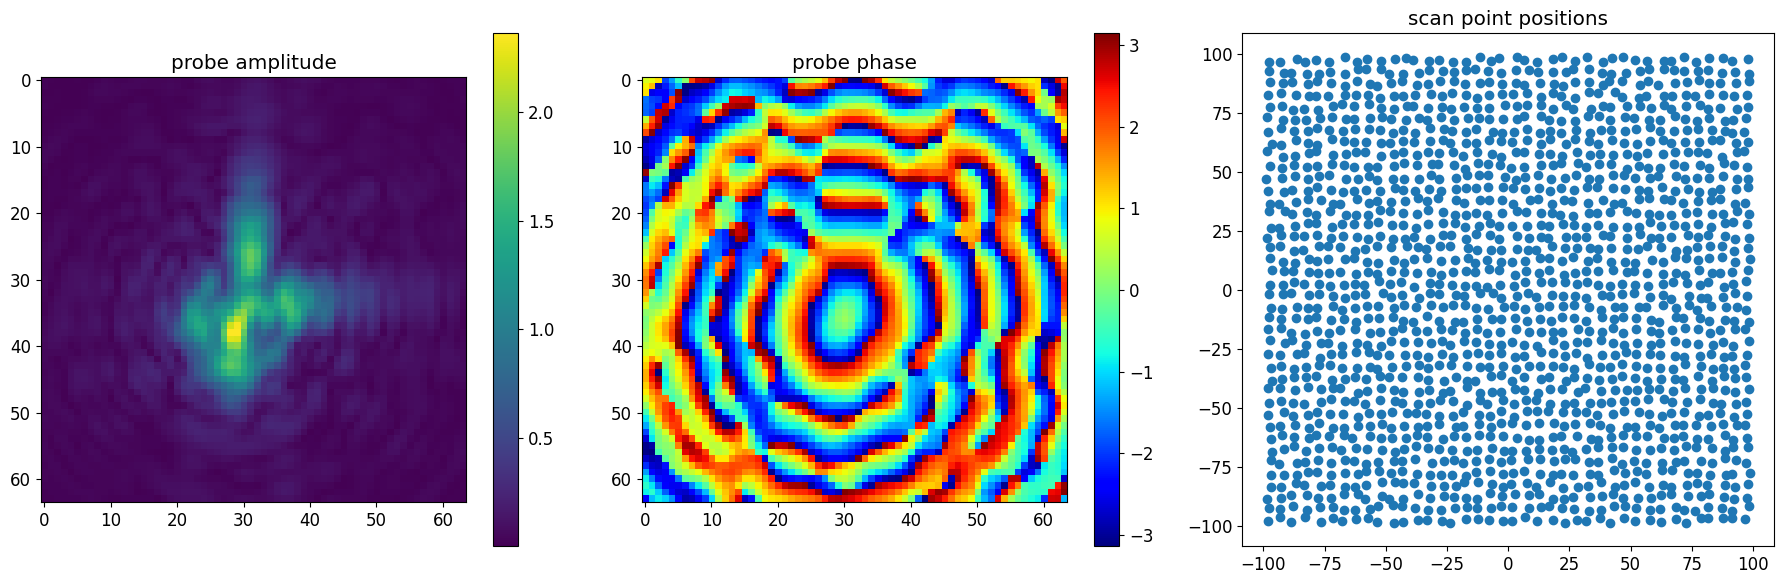

In [10]:
# Note the randomized scan point positions
probeshow(ptycho_dataset.test_data.probe, ptycho_dataset.test_data)

## Reconstruct the full test object image and compare to the ePIE reconstruction:

In [9]:
plt.imshow(np.angle(obj_tensor_full[1000, :, :, 0]))
plt.colorbar()

NameError: name 'obj_tensor_full' is not defined

phase min: -0.27846456 phase max: 2.3390985


/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/evaluation.py:81: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(cfg.get('intensity_scale') * X_test)[i, :, :, channel]


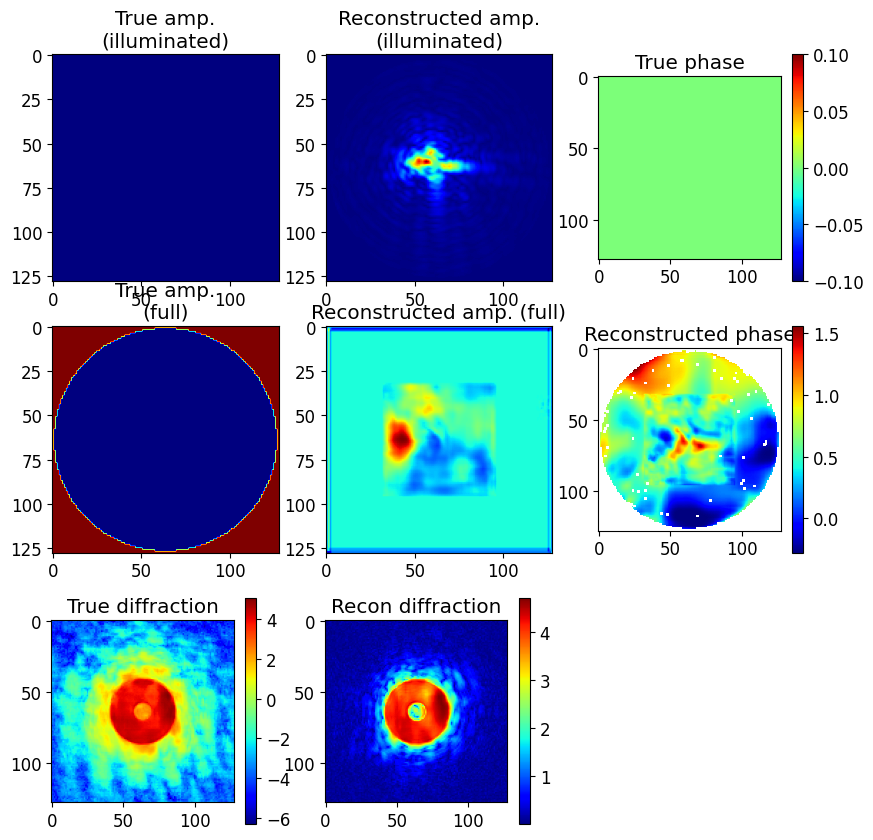

In [10]:
i = 600
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0,
                    crop = False);

phase min: -0.42276472 phase max: 2.846697


/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/evaluation.py:81: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(cfg.get('intensity_scale') * X_test)[i, :, :, channel]


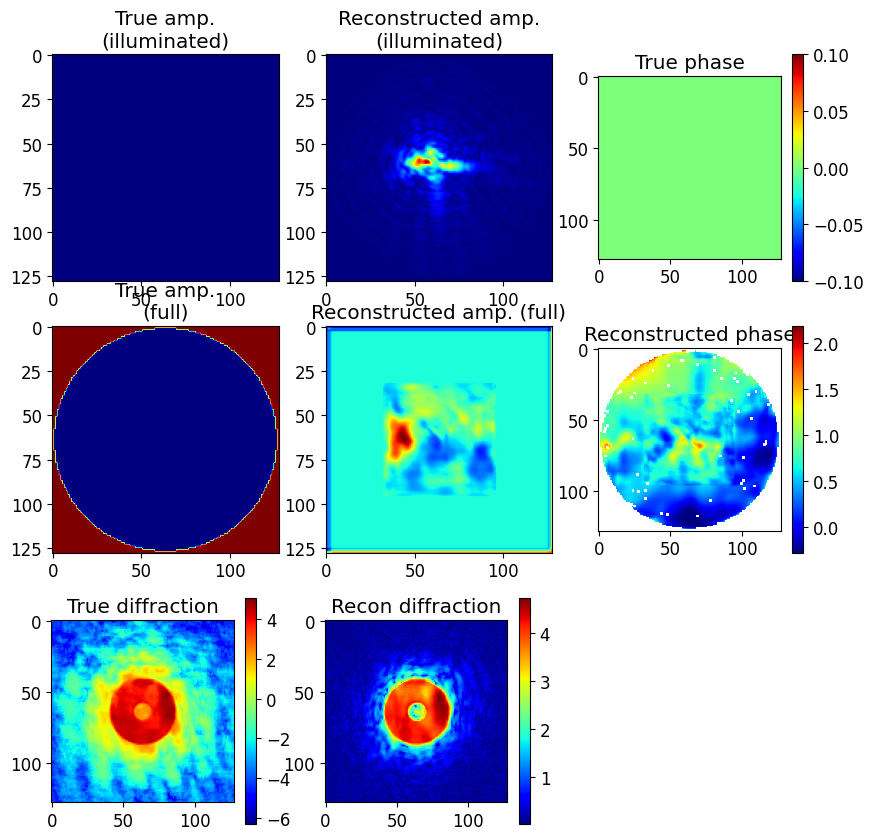

In [10]:
i = 600
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0,
                    crop = False);

In [14]:
global_offsets.max()

0.40301174615981

In [11]:
plt.imshow(np.angle(obj_tensor_full[1200]))

NameError: name 'obj_tensor_full' is not defined

50/50 [==============================] - 0s 9ms/step
PADDING SIZE: 99
PADDING SIZE: 99


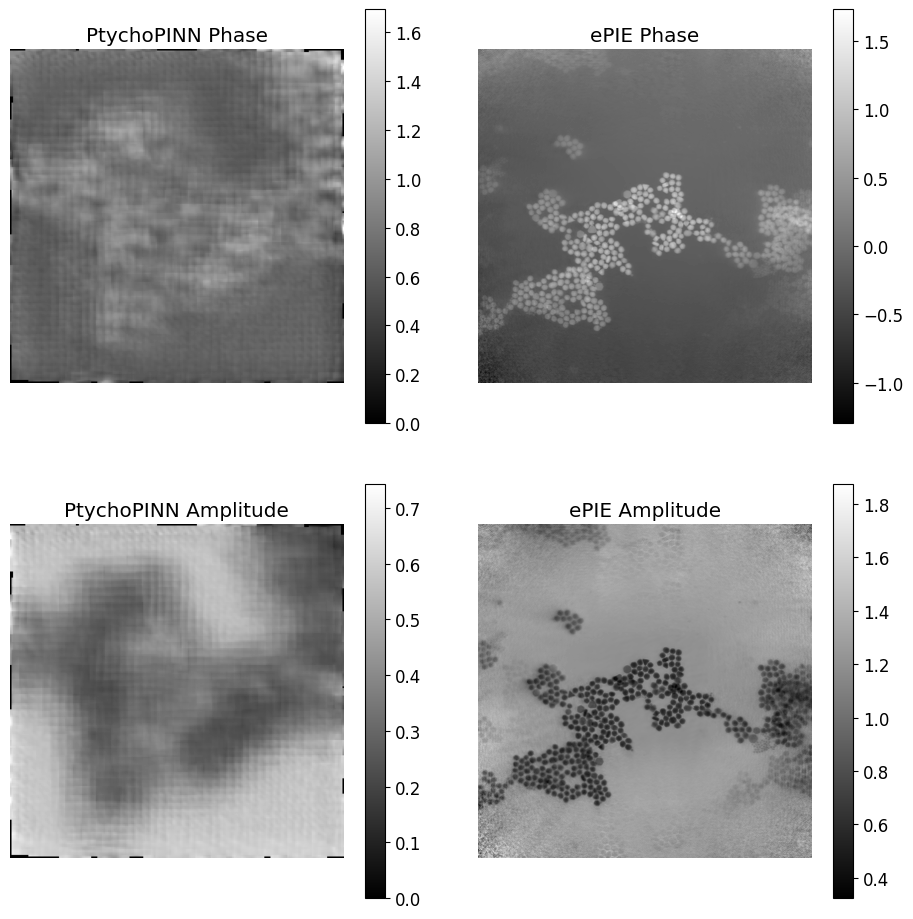

CPU times: user 8.18 s, sys: 520 ms, total: 8.7 s
Wall time: 8.23 s


In [14]:
%%time
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

50/50 [==============================] - 1s 9ms/step
PADDING SIZE: 99
PADDING SIZE: 99


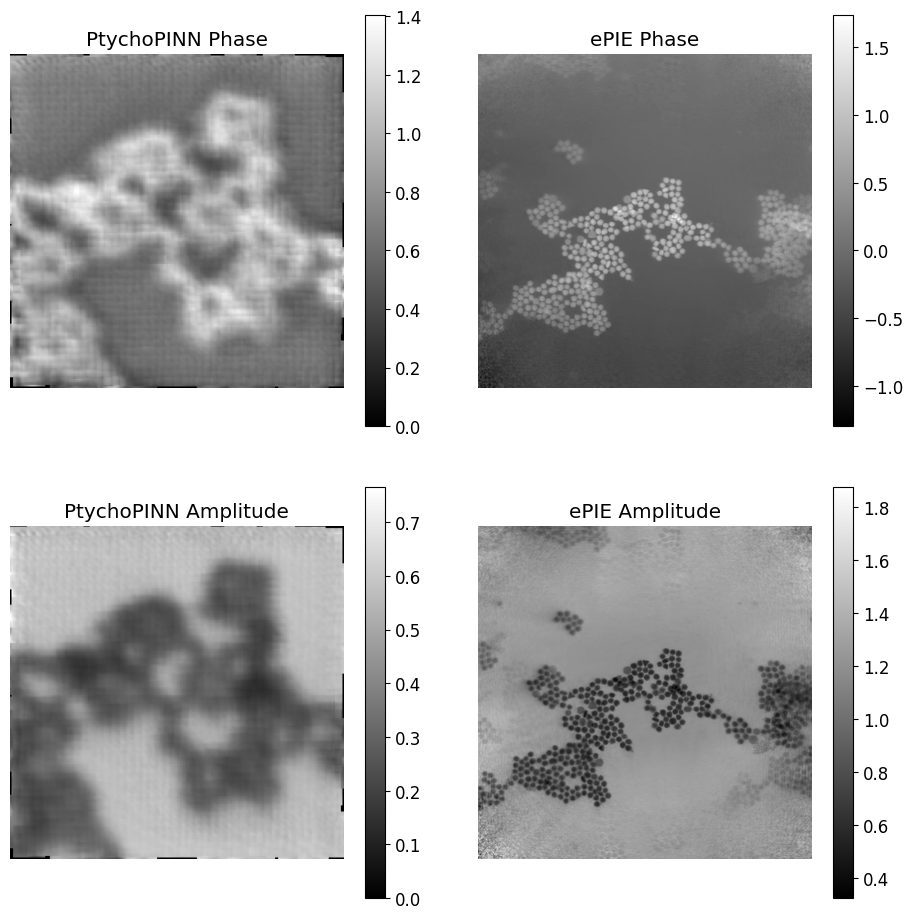

CPU times: user 8.95 s, sys: 2.45 s, total: 11.4 s
Wall time: 8.69 s


In [12]:
%%time
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

In [13]:
ptycho_pinn_phase.shape

(218, 218)

50/50 [==============================] - 1s 9ms/step
PADDING SIZE: 99
PADDING SIZE: 99


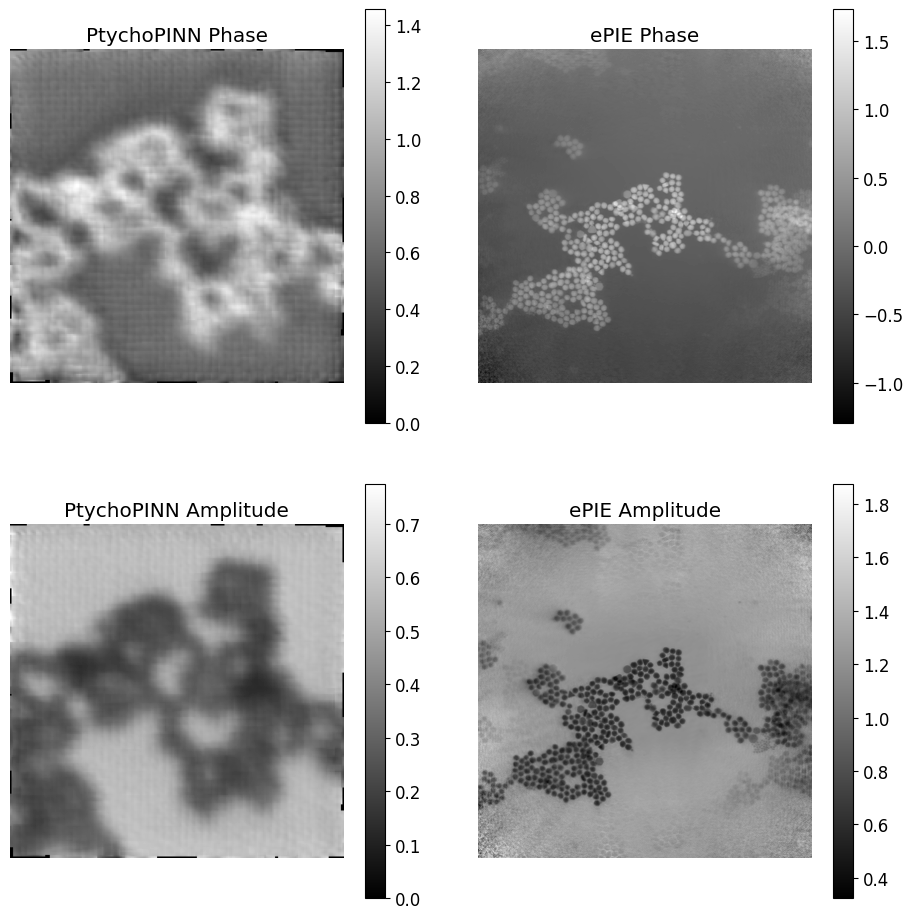

CPU times: user 8.12 s, sys: 579 ms, total: 8.7 s
Wall time: 8.31 s


In [12]:
%%time
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

In [13]:
from ptycho import baselines as bl

In [17]:
from importlib import reload
reload(bl)

<module 'ptycho.baselines' from '/home/ollie/anaconda3/envs/py310_3/lib/python3.10/site-packages/ptycho/baselines.py'>

In [19]:
baseline_model = bl.train((train_data.X[:, :, :, :1]), train_data.Y_I[:, :, :, :1], train_data.Y_phi[:, :, :, :1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [21]:
baseline_model

(<keras.src.engine.functional.Functional at 0x7251d01b73a0>,
 <keras.src.callbacks.History at 0x7251ac6097b0>)

In [33]:
np.mean(test_data.X)

0.14782986

In [22]:
baseline_pred_I, baseline_pred_phi = baseline_model[0].predict([test_data.X[:, :, :, 0] ])

50/50 [==============================] - 1s 17ms/step


In [1]:
baseline_pred_I.shape

NameError: name 'baseline_pred_I' is not defined

In [25]:
obj_image_ptychonn = loader.reassemble_position(hh.combine_complex(baseline_pred_I, baseline_pred_phi),
                                                -global_offsets[:, :, :, :] , M = 20)


PADDING SIZE: 99
PADDING SIZE: 99


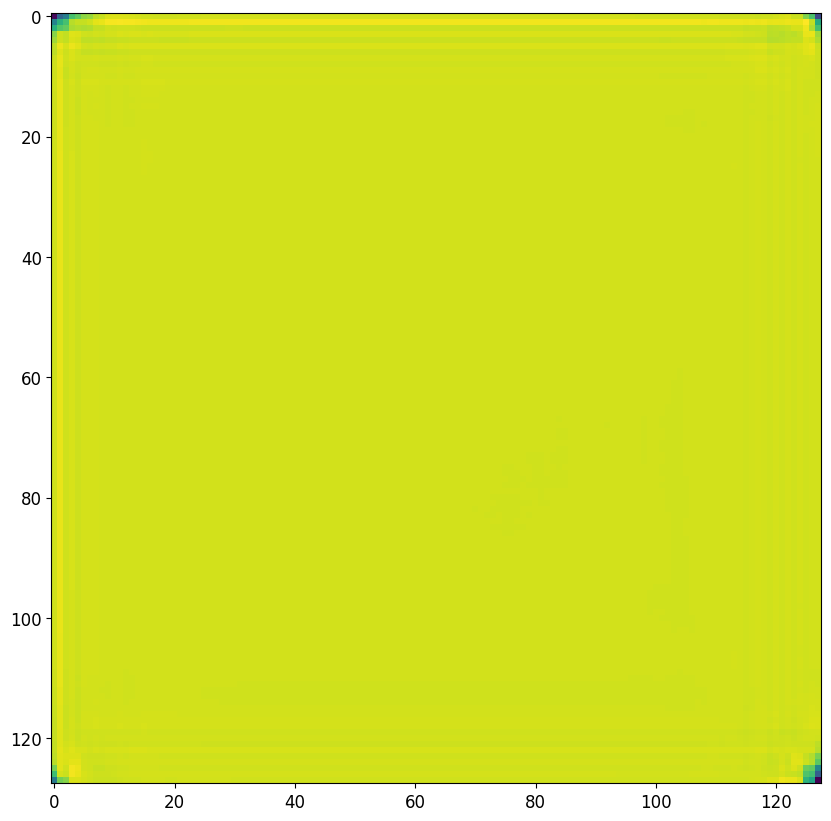

In [35]:
plt.imshow(baseline_pred_I[100])

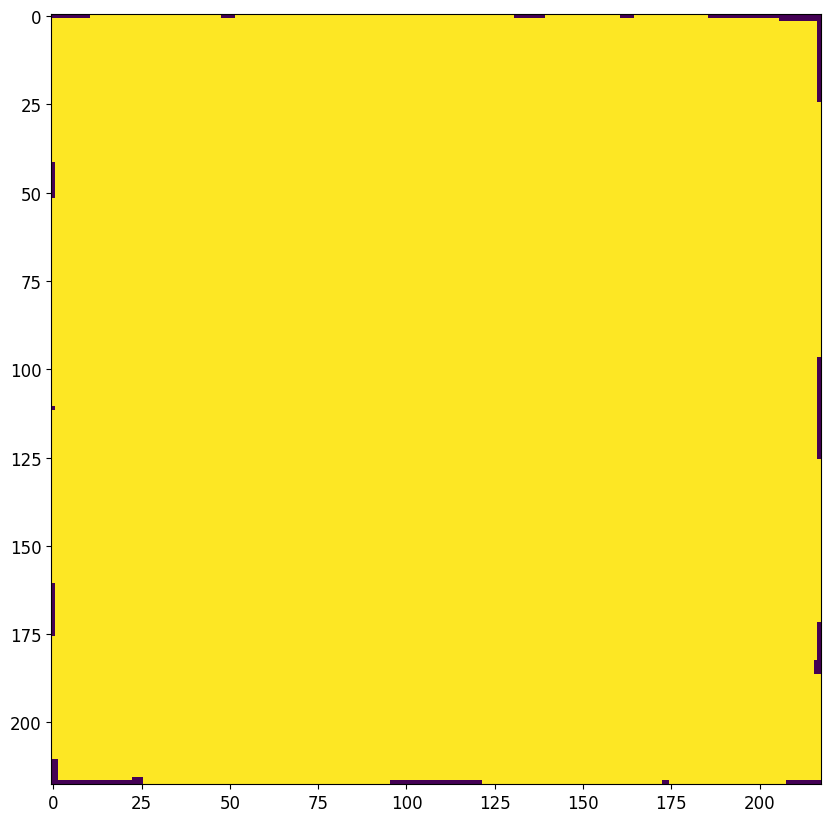

In [28]:
plt.imshow(np.abs(obj_image_ptychonn))

In [ ]:
%%time
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

50/50 [==============================] - 1s 9ms/step
PADDING SIZE: 99
PADDING SIZE: 99


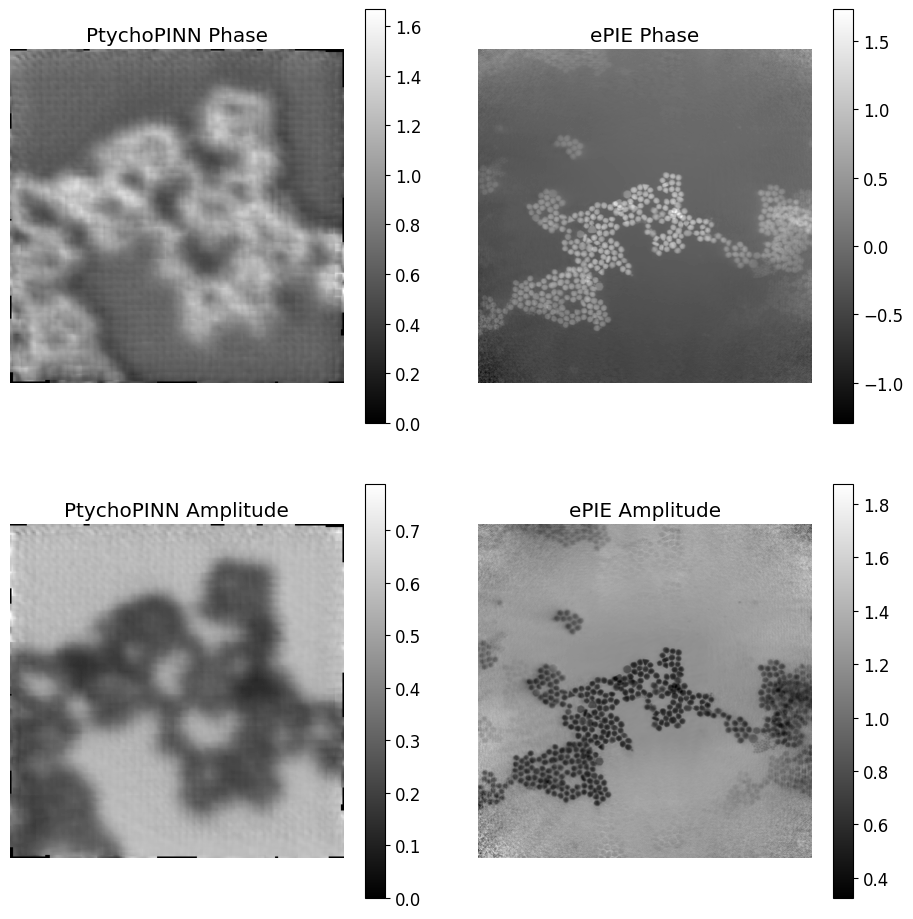

CPU times: user 8.01 s, sys: 567 ms, total: 8.58 s
Wall time: 8.21 s


In [12]:
%%time
test_data = ptycho_dataset.test_data
train_data = ptycho_dataset.train_data
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

In [2]:
ptycho_pinn_phase.shape

NameError: name 'ptycho_pinn_phase' is not defined

50/50 [==============================] - 1s 9ms/step
PADDING SIZE: 99
PADDING SIZE: 99


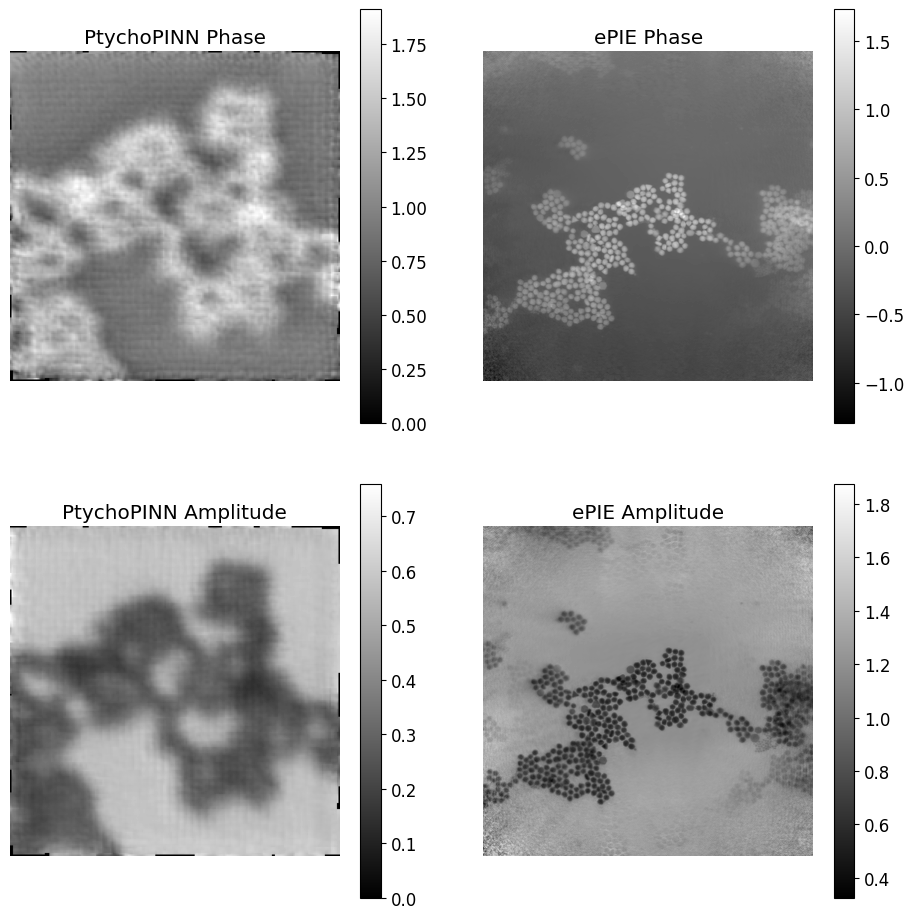

CPU times: user 8.18 s, sys: 558 ms, total: 8.74 s
Wall time: 8.33 s


In [11]:
%%time
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

In [17]:
ptycho_pinn_phase

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [3.1415925, 3.1415925, 3.1415925, ..., 0.       , 0.       ,
        0.       ],
       [3.1415925, 3.1415925, 3.1415925, ..., 3.1415925, 3.1415925,
        0.       ],
       ...,
       [0.       , 0.       , 3.1415925, ..., 3.1415925, 3.1415925,
        3.1415925],
       [0.       , 0.       , 3.1415925, ..., 3.1415925, 3.1415925,
        3.1415925],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

50/50 [==============================] - 0s 6ms/step
PADDING SIZE: 99
PADDING SIZE: 99


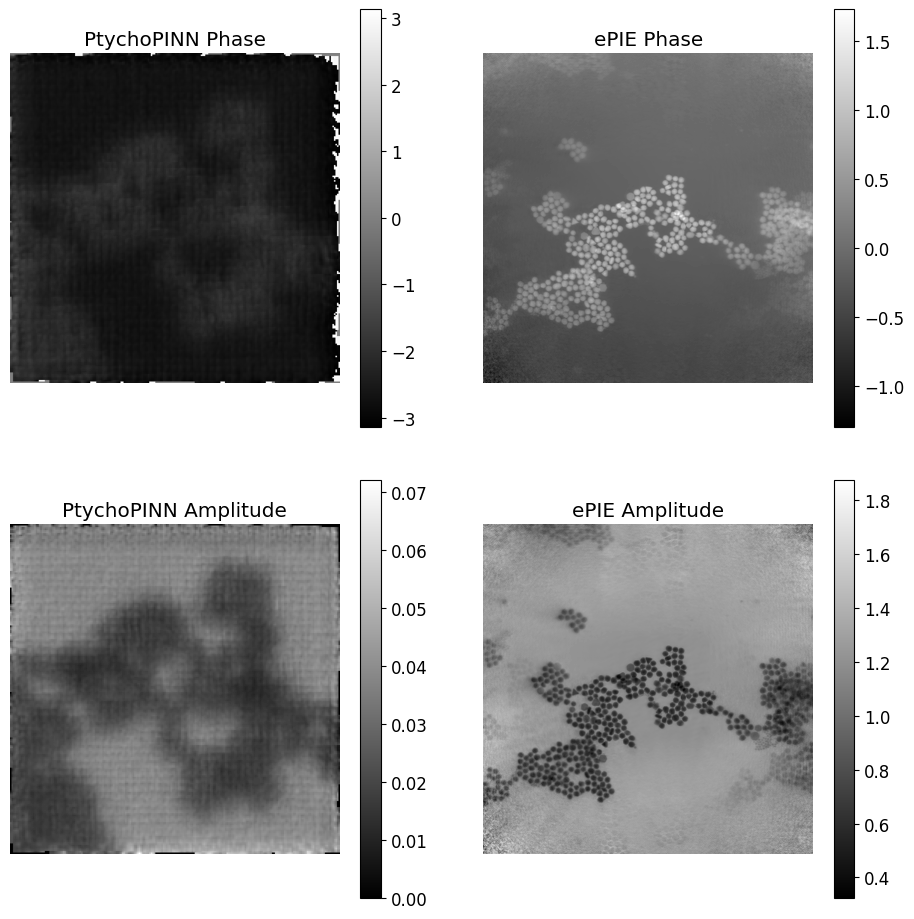

CPU times: user 7.66 s, sys: 411 ms, total: 8.07 s
Wall time: 7.64 s


In [11]:
%%time
from ptycho import loader

obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, -global_offsets[:, :, :, :] , M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>CALL
type=<class 'tensorflow.python.framework.ops.SymbolicTensor'>, shape=(None, 64, 64, 1), dtype=<dtype: 'float32'>
type=<class 'dict'>
<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>ERROR Input data is not picklable
<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>CALL
type=<class 'tensorflow.python.framework.ops.SymbolicTensor'>, shape=(None, 64, 64, 1), dtype=<dtype: 'float32'>
type=<class 'dict'>
<ptycho.tf_helper.reassemble_patches_position_real.reassemble_patches_position_real>ERROR Input data is not picklable
34/34 [==============================] - 0s 5ms/step
<ptycho.loader.reassemble_position.reassemble_position>CALL
type=<class 'numpy.ndarray'>, shape=(1087, 64, 64, 1), dtype=complex64, type=<class 'numpy.ndarray'>, shape=(1087, 1, 2, 1), dtype=float64
type=<class 'dict'>
<ptycho.loader.shift_and_sum.shift_and_sum>CALL


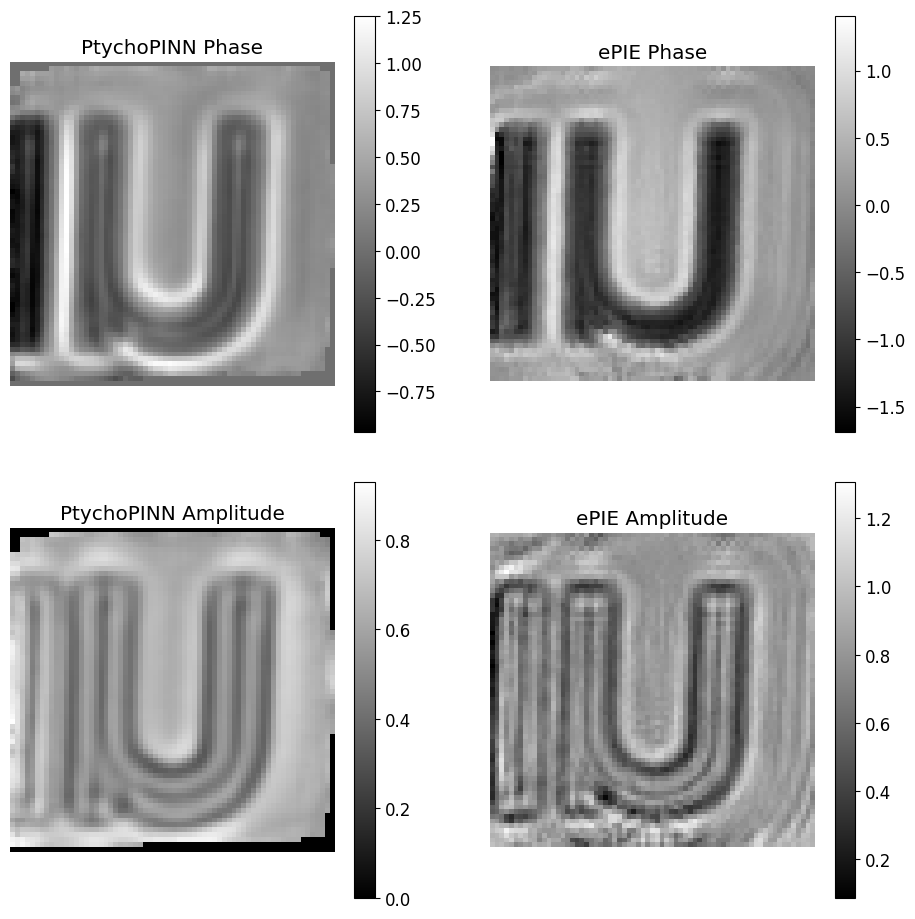

CPU times: user 6.02 s, sys: 967 ms, total: 6.98 s
Wall time: 6.6 s


In [11]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

102/102 [==============================] - 1s 6ms/step
PADDING SIZE: 22
PADDING SIZE: 22


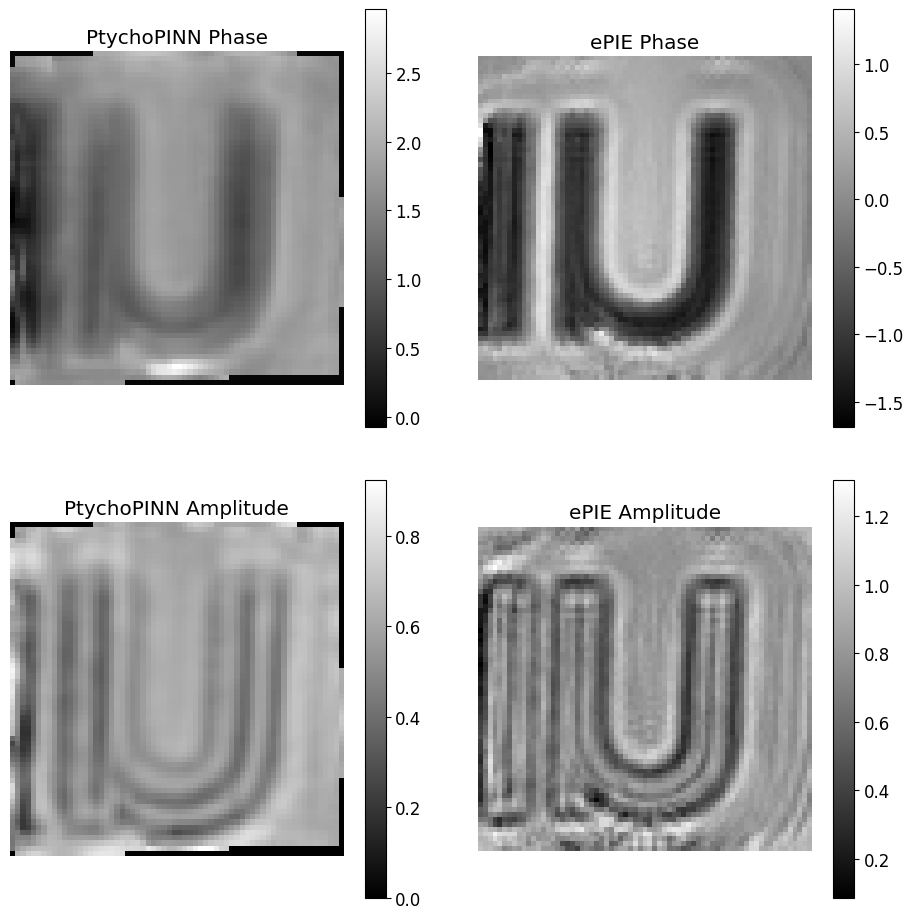

CPU times: user 1.28 s, sys: 588 ms, total: 1.87 s
Wall time: 1.68 s


In [9]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = recon_phase_ptychopinn[..., 0]
ptycho_pinn_amplitude = recon_amp_ptychopinn[..., 0]

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']), buffer=-20)
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']), buffer=-20)

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

Reconstruction for a single solution region:

phase min: -3.141591 phase max: 3.1415925


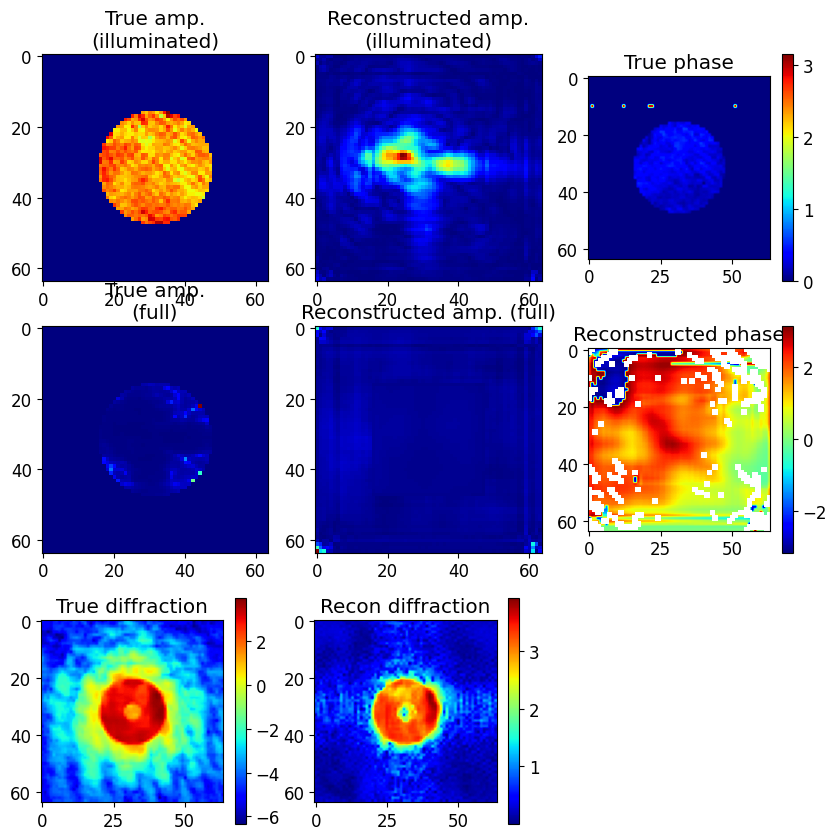

In [9]:
i = 600
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0, 0]), 0,
                    crop = False);

phase min: -3.141591 phase max: 3.1415925


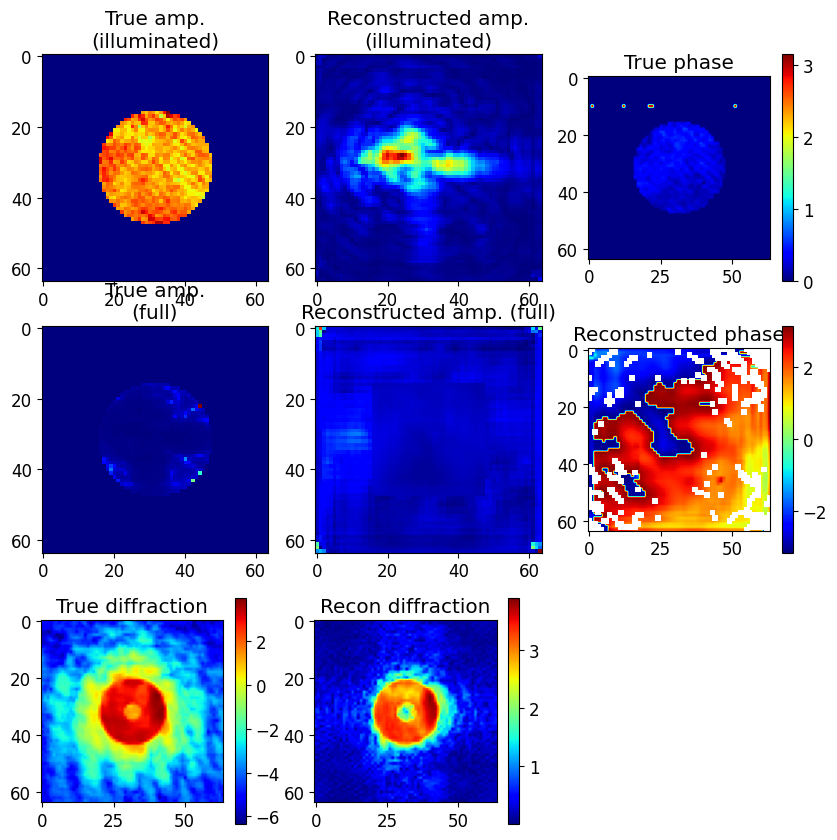

In [8]:
i = 600
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0, 0]), 0,
                    crop = False);

phase min: -3.1415672 phase max: 3.141365


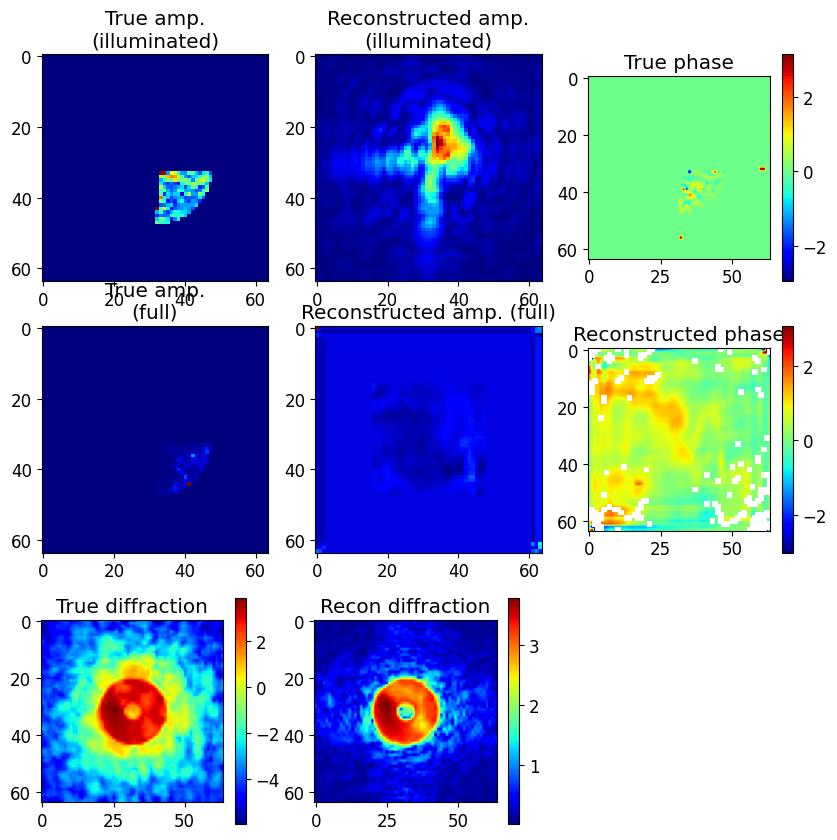

In [8]:
i = 800
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0, 0]), 0,
                    crop = False);

In [ ]:
# TODO: is the loss different here from on the main branch?

In [15]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
# moved to logging.py

# import os
# import json
# from typing import List, Tuple, Union
# from ptycho.logging import LoggedDataNotFoundError, load_logged_data

# def get_type_and_dim(serialized_data: str) -> str:
#     if serialized_data.startswith("NumPy array"):
#         shape_start = serialized_data.find("shape") + len("shape")
#         shape_end = serialized_data.find("and data type")
#         shape = eval(serialized_data[shape_start:shape_end].strip())
#         dtype = serialized_data[shape_end + len("and data type"):].strip()
#         return f"NumPy array, shape: {shape}, dtype: {dtype}"
#     elif serialized_data.startswith("TensorFlow tensor"):
#         shape_start = serialized_data.find("shape") + len("shape")
#         shape_end = serialized_data.find("and data type")
#         shape = eval(serialized_data[shape_start:shape_end].strip())
#         dtype = serialized_data[shape_end + len("and data type"):].strip()
#         return f"TensorFlow tensor, shape: {shape}, dtype: {dtype}"
#     else:
#         return serialized_data.split(" ")[0]

# def process_log_file(module_path: str, function_name: str) -> None:
#     if function_name.startswith("__init__"):
#         return

#     invocation_index = 0
#     try:
#         inputs, outputs = load_logged_data(module_path, function_name, invocation_index)
#     except LoggedDataNotFoundError:
#         return

#     input_types_dims = []
#     for input_data in inputs["args"]:
#         input_types_dims.append(get_type_and_dim(input_data))
#     for input_name, input_data in inputs["kwargs"].items():
#         input_types_dims.append(f"{input_name}: {get_type_and_dim(input_data)}")

#     output_type_dim = get_type_and_dim(outputs)

#     print(f"Module: {module_path}, Function: {function_name}")
#     print("Input types and dimensionalities:")
#     for input_type_dim in input_types_dims:
#         print(f"  - {input_type_dim}")
#     print(f"Output type and dimensionality: {output_type_dim}")
#     print()

# def extract_logged_data(log_directory: str) -> None:
#     for module_name in os.listdir(log_directory):
#         module_directory = os.path.join(log_directory, module_name)
#         for log_file in os.listdir(module_directory):
#             function_name = log_file.split("_")[0]
#             process_log_file(module_name, function_name)

# def main() -> None:
#     log_directory = "logs/"
#     extract_logged_data(log_directory)

# if __name__ == "__main__":
#     main()

Module: ptycho.loader, Function: get
Input types and dimensionalities:
  - TensorFlow tensor, shape: (227, 226), dtype: <dtype: 'float64'>
  - NumPy array, shape: (512, 1, 2, 1), dtype: float64
  - TensorFlow tensor, shape: (512, 1, 2, 1), dtype: <dtype: 'float64'>
Output type and dimensionality: TensorFlow tensor, shape: (512, 64, 64, 1), dtype: <dtype: 'float64'>

Module: ptycho.loader, Function: 
Input types and dimensionalities:
  - <class
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512,), dtype: float64
  - NumPy array, shape: (512, 64, 64), dtype: float64
  - NumPy array, shape: (64, 64), dtype: complex128
  - NumPy array, shape: (512,), dtype: int64
  - objectGuess: NumPy array, shape: (227, 226), dtype: complex128
Output type and dimensionality: <class

Module: ptycho.loader, Function: get
Input types and dimensionalities:
  - TensorFlow tensor, shape: (227,